In [ ]:
pip install gdal rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 447 kB/s 


In [ ]:
pip install shapely pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.9 MB/s 


In [ ]:
# optional : If you are using Google colab, you can connect your tif file from Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
from rasterio.plot import show

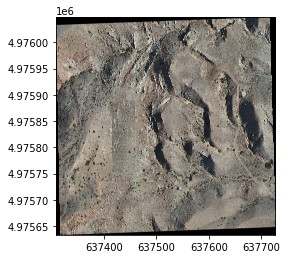

EPSG:32612


In [ ]:
parcel = rasterio.open("/content/drive/MyDrive/Geotiff/CityDaoClippedPatchedv5.tif")
show(parcel)
print(parcel.crs)

In [ ]:
# optional to check crs of geojson
!pip install fiona
import fiona
with fiona.open("/content/drive/MyDrive/Geotiff/Launch/plots_v1-IPFS.geojson", 'r') as shapefile:
  print(shapefile.crs)

{'init': 'epsg:4326'}


In [ ]:
import json 
with open("/content/drive/MyDrive/Geotiff/Launch/plots_v1-IPFS.geojson") as f:
  features = json.load(f)["features"]

6369
{'aspect': 'S', 'district': 'Tendie Town', 'rock_pct': 0, 'other_pct': 100, 'veg_pct': 0, 'elevation': 'Lower', 'feature': 'Gulch & Gulley Frontage', 'slope': 'Steep', 'PLOT_ID': 6194}
6194


Make json for IPFS

In [ ]:
import json 
with open("/content/drive/MyDrive/Geotiff/Launch/plots_v1-IPFS.geojson") as f:
  features = json.load(f)["features"]

  # Debugging metadata of geojson
  # print(len(features))
  # print(features[1]["properties"])
  # print(features[1]["properties"]["aspect"])
  # print(features[1]["properties"]["district"])


6369
{'aspect': 'NNW', 'district': 'LFG Heights', 'rock_pct': 0, 'other_pct': 79, 'veg_pct': 21, 'elevation': 'Upper', 'feature': 'Shoshone National Forest Boundary', 'slope': 'Extremely Steep', 'PLOT_ID': 455}
{'aspect': 'NNW', 'district': 'LFG Heights', 'rock_pct': 0, 'other_pct': 79, 'veg_pct': 21, 'elevation': 'Upper', 'feature': 'Shoshone National Forest Boundary', 'slope': 'Extremely Steep', 'PLOT_ID': 455}
NNW
LFG Heights
0
79
21
Upper
Shoshone National Forest Boundary
Extremely Steep


# Masking subplot images from tif file for NFT using geojson 


In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageOps

In [ ]:
import json
from shapely.geometry import shape, GeometryCollection, Polygon


from functools import partial
import shapely.ops
import pyproj
import rasterio.mask

from IPython.display import Image, display

# Code if CRS Transformation needed
tfm = partial(pyproj.transform, 
                pyproj.Proj(init="epsg:4326"), 
                pyproj.Proj(init="epsg:32612"))


with open("/content/drive/MyDrive/Geotiff/Launch/plots_v1-IPFS.geojson") as f:
  features = json.load(f)["features"]

  print(len(features))

  global_plot_id = len(features)
  #global_plot_id = 15

  
  for i in range(len(features)):

    id = features[i]["properties"]["PLOT_ID"]

    geopoly = GeometryCollection([shape(features[i]["geometry"]).buffer(0)])
  

    geotransform = shapely.ops.transform(tfm, geopoly)

    with rasterio.open('/content/drive/MyDrive/Geotiff/CityDaoClippedPatchedv5.tif') as src:

      # adding outlier plots  of near zero area
      if (id == 6194 or id == 6280):

        continue

 
      png_meta = src.meta

      out_image, out_transform = rasterio.mask.mask(src, geotransform, crop=True, all_touched=False,pad_width=0,filled=True,  )
      
      png_meta.update({
          "driver": 'PNG',
          'height': out_image.shape[1],
          'width': out_image.shape[2],
          'transform': out_transform,
      })

      with rasterio.open("/content/original/"+ str(id) + ".png", 'w', **png_meta) as dst:

          dst.write(out_image)

      path = "/content/original/" + str(id) + ".png"
      


# Image Post Processing 

1. White Background to Transparent
2. Drawing Grid
3. Add Plot Id Text Info

In [ ]:
import numpy as np
for id in range(1, global_plot_id):

  #i is referred as id here
  path = "/content/original/" + str(id) + ".png"
  img = Image.open(path)
 

  rgba = img.convert("RGBA")
  datas = rgba.getdata()

  #print(datas)

  width = img.size[0] 
  height = img.size[1] 

  newData = []

  for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:  # finding white colour by its RGB value
        # storing a transparent value when we find a black colour
        newData.append((0, 0, 0, 0))
    else:
        newData.append(item)  # other colours remain unchanged
  
  rgba.putdata(newData)

  path = '/content/transparent/'+ str(id) + ".png"
    
  rgba.save(path, "PNG" )


# Draw Grid

Square Grid Resizing Strategy

In [ ]:
from PIL import ImageColor

for i in range(1,global_plot_id):

  print(i)

  path = '/content/transparent/'+ str(i) + ".png"  
  my_image = Image.open(path)

  #print("Original Image")
  #display(my_image)

  delta = 25

  right = delta
  left =  delta
  top =  delta
  bottom =  delta
    
  width, height = my_image.size

  square_dim = max(width,height)
    
  new_width = square_dim + right + left
  new_height = square_dim + top + bottom


  result = Image.new(my_image.mode, (new_width, new_height), (0, 0, 0))

  
  #Draw Grid
  draw = ImageDraw.Draw(result)

  #offset = 35
  offset = 0


  step_size = 50
  x = result.width / 2

  y_start = 0 + offset
  y_end = result.height - offset

  for x in range(offset, result.width - offset, step_size):
        line = ((x, y_start), (x, y_end))
        draw.line(line, fill=ImageColor.getrgb("#00FFA8"))
  
  x_start = 0 + offset
  x_end = result.width - offset

  for y in range(offset, result.height - offset, step_size):
      line = ((x_start, y), (x_end, y))
      draw.line(line, fill=ImageColor.getrgb("#00FFA8"))

  del draw


  #paste third parameter is used as mask (IMP.)
  result.paste(my_image, (delta, delta), my_image)


  # border color
  color = ImageColor.getrgb("#00FFA8")

  thickness = 3
  border = (thickness, thickness, thickness, thickness)

  result = ImageOps.expand(result, border=border, fill=color)
  


  # Resize the image
  result = result.resize((320,320), resample=1) 

  delta = 15

  right = 0 + delta
  left = 0 + delta
  top = 0 + delta
  bottom = 0+ delta
    
  width, height = result.size
    
  new_width = width + right + left
  new_height = height + top + bottom
    
  result2 = Image.new(result.mode, (new_width, new_height), (0, 0, 0))

  result2.paste(result, (left, top), result) 

  padded_path = '/content/fingrid/' + str(i) + ".png"
    
  result2.save(padded_path )


Add padding and grid in one operation

Check all 6k images with geojson without save image for overlapp issues

Add text annotation 

In [ ]:
for i in range(1,global_plot_id):

  padded_path = '/content/fingrid/' + str(i) + ".png"
  padded_img = Image.open(padded_path )
  #Padding to make it 350x350

  delta = 15

  right = 0 + delta
  left = 0 + delta
  top = 0 + delta
  bottom = 0+ delta
    
  width, height = padded_img.size
    
  new_width = width + right + left
  new_height = height + top + bottom
    
  result = Image.new(padded_img.mode, (new_width, new_height), (0, 0, 0))

  result.paste(padded_img, (left, top), padded_img)
  
  #print(padded_img.size)

  # Padded Image
  #display(padded_img)

  # Annotated Image

  #title_font = ImageFont.truetype('/content/drive/MyDrive/Geotiff/font/Inconsolata-Regular.ttf', 15)
  #plot_id = "Plot #" + str(i)
  #title_text = "Parcel 0"
  #area = "CityDAO"

  #district metadata
  #zone= "Degen Valley"

  #image_editable = ImageDraw.Draw(result)
  #right_start = 35
  #left_end = 35

  #image_editable.text((right_start,8), plot_id , (54, 217, 81), font=title_font)
  #image_editable.text(((result.size[0])-110,8), title_text, (54, 217, 81), font=title_font)
  #image_editable.text(((result.size[0])-110,(result.size[1])-40), area, (54, 217, 81), font=title_font)
  #image_editable.text((right_start,(result.size[1])-40), zone, (54, 217, 81), font=title_font)

  

  
  edited_imgpath = '/content/final/' + str(i) + ".png"

  result.save(edited_imgpath)

  final_img = Image.open(edited_imgpath)
  
  #print(final_img.size)
  #Final Image
  #display(final_img)